---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiantes: **Brandon Cascante, B71732 & Andrés Quesada, B78911 & Josué Flores, B62696**
- Grupo: **2**
- Subgrupo: **-**

# `P5` - *Procesos M/M/s*

> El caso especial de los procesos aleatorios donde existen "estados" y "transiciones" entre estos estados, las cadenas de Markov modelan las probabilidades de transición y el tiempo de permanencia entre cada estado. En particular, la teoría de colas describe la evolución del número de elementos en la fila, dado un flujo de entrada y un flujo de salida.

---

---

Es menester tomar una decisión con respecto al número de "servidores" necesarios para cierto proceso de vacunación, de forma tal que el sistema no exceda 50 personas en fila durante el 95% del tiempo de servicio. 

En un estudio de afluencia y del tiempo de servicio se asumen y determinan los siguientes parámetros:

- La tasa de llegada $\lambda$ es constante durante ocho horas de funcionamiento y tiene un valor de $\lambda = 4$ personas por minuto.

- La tasa de servicio $\nu$ de cada "servidor" (es decir, personal de salud tomando datos y vacunando) es constante durante ocho horas de funcionamiento y tiene un valor de $\nu = 0.25$ personas por minuto.

Entonces,

- (40%) Hacer la determinación teórica del número $s$ de servidores necesarios para cumplir el requisito.
- (60%) Modificar el código provisto para simular y corroborar el resultado anterior y crear al menos dos gráficas que muestren esta simulación.

#### Sobre la presentación

El trabajo debe entregarse como un *notebook* de Jupyter nuevo (sin incluir información de este enunciado), en la forma de reporte. La primera parte de las asignaciones debe ser desarrollada por completo y en orden, editando las ecuaciones en $\LaTeX$. La segunda parte debe incluir el código desarrollado y sus resultados. Esto es enviado vía Mediación Virtual, uno por grupo.

# Parte 1.
## Determinación teórica del número  𝑠  de servidores necesarios para cumplir el requisito.
Según lo descrito en el enunciado se tiene que:
$$
\lambda= 4  \frac{personas}{minuto}
$$


$$
\nu = 0.25  \frac{personas} {minuto}
$$

Por lo que para calcular $\rho$ se tiene que:

$$
\rho=\frac{\lambda}{s\cdot \nu}=\frac{4}{s\cdot 0.25}=\frac{16}{s}
$$

Dado que la longitud de la fila $L_{q}$ es:
$$
L_{q}=i-1 
$$

Recordando que la cantidad máxima de personas en la fila es de 50 personas se tiene que la cantidad de pacientes $(i)$ en el sistema es:

$$
i=L_{q}+1=50+1=51
$$


Sabiendo lo anterior, se va considerará la suma de probabilidades del estado estable y  la condición de ruptura menor según los datos dados por el enunciado, tal y como se muestra en la siguiente ecuación:

$$
P( \text{51 o más personas en el sistema} ) = \sum_{i=51}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{50} (1 - \rho) \rho^i = \rho^{51}
$$

Ahora bien, debido a que se requiere que el sistema no exceda 50 personas en fila durante el 95% del tiempo de servicio, se tiene que la probabilidad de que hayan más de 50 personas en la fila debe de ser menor o igual a 0.05, por lo que se tiene la siguiente inecuación:

$$
\rho^{51} \leq 0.05
$$

Al sustituir el valor de  $\rho$  obtenido con anterioridad en la inecuación descrita anteriormente se tiene:

$$
\left(\frac{16}{s} \right)^{51} \leq 0.05
$$

Al despejar $s$ se tiene lo siguiente:

$$
16 \sqrt[51]{\frac{1}{0.05}} \leq s
$$

Por lo que la cantidad de servidores $s$ es:

$$
16.97 \leq s
$$


Por lo tanto, el número de servidores necesarios para cumplir con la condición de mantener menos de 50 personas en la cola en 95% del tiempo es de $17$ servidores $s$.

# Parte 2.
## Modificación del código provisto para simular y corroborar el resultado anterior y crear al menos dos gráficas que muestren esta simulación.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def simulación(s): # Función que grafica la cantidad de pacientes en el tiempo

    # Número de personas                 
    N = 3000

    # Parámetro de llegada (personas/segundos)
    lam = 4/60

    # Parámetro de servicio (servicios/segundos)
    nu = s*(0.25/60)

    # Distribución de los tiempos de llegada entre cada paciente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada paciente
    Y = stats.expon(scale = 1/nu)

    # Intervalos entre llegadas (segundos desde último paciente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida
    
    # Tiempos en que recibe atención cada i-ésimo paciente (!= que llega)
    t_atencion = [inicio]
    for i in range(1, N):
        inicio = np.max((t_llegadas[i], fin))
        fin = inicio + t_servicio[i]
        t_atencion.append(inicio)

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de pacientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 51

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)
    
    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Número de servidores =', str(s)) 
    print('Tiempo con más de {} solicitudes en fila:'.format(P-1))
    print('\t {:0.2f}%'.format(100*fraccion))
    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))
    
    Title = " Simulación de vacunación para " + str(s) + " servidores."
    
    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-1)))
    plt.ylabel('Pacientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.title(Title)
    plt.xlim((0, 30000)) # Se definió el límite para un rango mayor a 8 horas 28800s
    plt.show()

### Primera simulación:
Se realiza la simulación con 17 servidores para demostrar que para mayor o igual a 17 servidores se cumple lo estipulado

Parámetro lambda = 4.0
Parámetro nu = 4.25
Número de servidores = 17
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 13.01 horas.


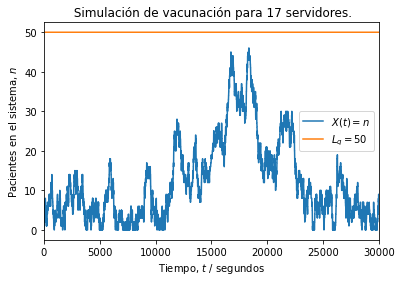

Parámetro lambda = 4.0
Parámetro nu = 4.25
Número de servidores = 17
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 12.95 horas.


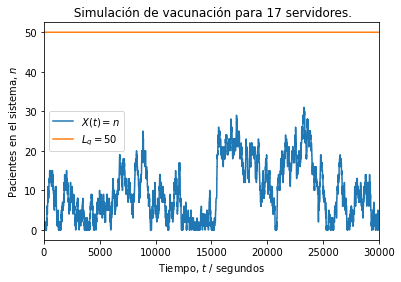

In [2]:
s1 = 17
simulación(s1) # Simulación para 17 servidores
simulación(s1) # Se realiza dos similuaciones para corroborar que funcina correctamente

### Segunda simulación:
Se eligen 14 servidores para verificar que no se cumple lo estipulado

Parámetro lambda = 4.0
Parámetro nu = 3.5
Número de servidores = 14
Tiempo con más de 50 solicitudes en fila:
	 79.37%
	 No cumple con la especificación.
Simulación es equivalente a 14.68 horas.


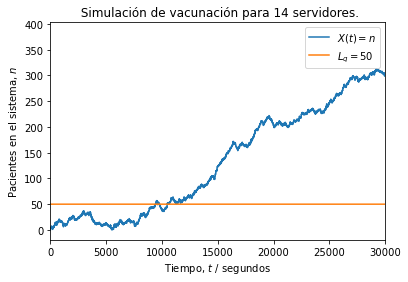

Parámetro lambda = 4.0
Parámetro nu = 3.5
Número de servidores = 14
Tiempo con más de 50 solicitudes en fila:
	 88.42%
	 No cumple con la especificación.
Simulación es equivalente a 14.72 horas.


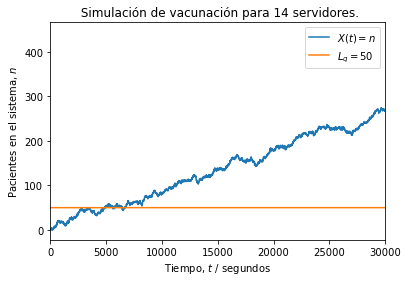

In [3]:
s2 = 14
simulación(s2) # Simulación para 14 servidores
simulación(s2) # Se realiza dos similuaciones para corroborar que funcina correctamente

### Tercera simulación:
Se realiza la simulación con 35 servidores para demostrar que para mayor a 17 servidores el servicio mejora.

Parámetro lambda = 4.0
Parámetro nu = 8.75
Número de servidores = 35
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 13.15 horas.


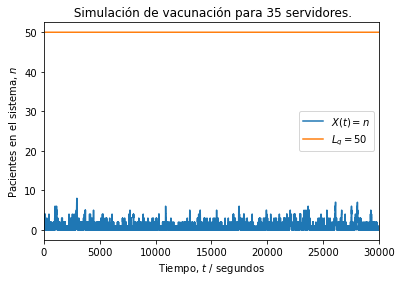

Parámetro lambda = 4.0
Parámetro nu = 8.75
Número de servidores = 35
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 12.92 horas.


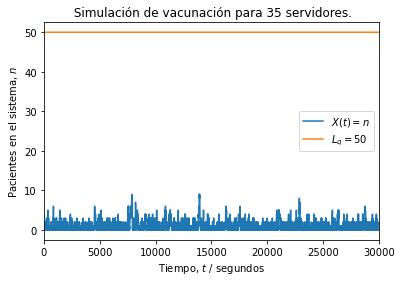

In [4]:
s3 = 35
simulación(s3) # Simulación para 35 servidores
simulación(s3) # Se realiza dos similuaciones para corroborar que funcina correctamente

## Conclusiones: 
- Se puede observar con las simulaciones realizadas en donde las gráficas de la simulación con **s2** servidores no se cumple con la condición necesaria.

- Con las simulaciones de **s1** y **s3** se determina que mediante más servidores se implementen las gráficas siempre se mantendran por debajo de la línea naranja que establece la condición mínima.

- Con una tasa de llegada de 4 personas por minuto y una tasa de servicio por servidor de 0.25 personas por minuto, para así no exceder la 50 personas en la fila durante el 95% del tiempo se debe tener la cantidad de 17 o más servidores.

- Conforme la cantidad de servidores aumenta la cantidad de personas por servidor va a disminuir.

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---